In [36]:
import copy as cp
import itertools
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from photonic_circuit_solver import *
import time

class RingState:
    """
    Class for working with and storing information about an n node ring state
    """

    def __init__(self, nodes:int):
        """
        Initializes class

        Parameters:
        - nodes : Number of nodes the graph state contains
        """

        self.nodes = nodes
        self.orderings = list()
        self.data = list()
    
    def __getitem__(self, index:int):
        """
        Returns ordering at index

        Parameters:
        - index : Index of desired ordering from list of unique orderings

        Returns:
        - self.orderings[index] : Ordering at index, returns none if an ordering does not exist at the index
        """

        return self.orderings[index] if self.orderings else None
    
    def get_orderings(self):
        """
        Generates all possible permutation of 1 through n-1, prepending each permuation with 0.
        If a permutation's first nonzero element is greater than the last element, it has already been 
        processed, and is equivalent to some element in the list of orderings.
        Each ordering is created using the form [0, 1], [1, 2], ... [n-1, 0].
        """

        time_start = time.time()

        permutations = [list(perm) for perm in itertools.permutations(range(self.nodes)[1:], self.nodes - 1)]
        for permutation in permutations:
            if permutation[0] == self.nodes-1:
                break
            elif permutation[0] > permutation[-1]:
                pass
            else:
                permutation.insert(0, 0)
                ordering = []
                for i in range(self.nodes):
                    edge = [permutation[i], permutation[i+1]] if i != self.nodes-1 else [permutation[i], permutation[0]] 
                    ordering.append(edge)
                self.orderings.append(ordering)
        
        print("Time taken :", round((time.time()-time_start) * 1000, 3), "ms")
    
    def get_lowest(self, max=None):
        """
        Finds the ordering with the least number of CNOTs and Hadamards and the lowest depth.
        Does a simple search across all orderings, creating a qiskit circuit for each and counting
        the number of CNOTs and Hadamards it consists of. All circuits contain a number of cnots
        equal to the number of nodes, so they are not accounted for.

        Parameters:
        - max : Maximum index to search up to

        Returns:
        - self.data[l_index] : Data from the lowest index
        """

        time_start = time.time()

        max = len(self.orderings) if max == None else max
        index = 0
        for ordering in self.orderings[0:max]:
            qc = qiskit_circuit_solver(Stabilizer(edgelist=ordering))
            qcd = dict(qc.count_ops())
            num_cnot = qcd.get('cx') - self.nodes
            num_hadamard = qcd.get('h')
            depth = qc.depth()
            emitters = qc.num_qubits - self.nodes
            if index == 0:
                l_index = index
            else:
                cnot_check = num_cnot < self.data[l_index][1][1]
                hadamard_check = num_cnot == self.data[l_index][1][1] and num_hadamard < self.data[l_index][2][1]
                depth_check = num_cnot == self.data[l_index][1][1] and num_hadamard == self.data[l_index][2][1] and depth < self.data[l_index][4][1]

                if cnot_check or hadamard_check or depth_check:
                    print("Previous lowest index :", l_index, "| New lowest index :", index)
                    l_index = index
                
            ordering_data = [["Index:", index], ["# CNOT:", num_cnot], ["# Hadamard:", num_hadamard], ["# Emitter:", emitters], ["Depth:", depth]]
            self.data.append(ordering_data)
            index += 1

        print("Time taken :", round((time.time()-time_start) * 1000, 3), "ms")

        return self.data[l_index]

    def plot_data(self, sort_by:int=0):
        """
        Plots all data from get_lowest as a pyplot

        Parameters:
        - sort_by : The index of the values to sort by (eg. 1 would be the number of CNOTs)
        """

        def sort_key(listed):
            return listed[sort_by][1]
        plot_data = cp.deepcopy(self.data)
        plot_data.sort(key=sort_key)
        plot_data = np.array(plot_data)

        cnot_data = [int(i) for i in plot_data[:,1][:,1]]
        had_data = [int(i) for i in plot_data[:,2][:,1]]
        emit_data = [int(i) for i in plot_data[:,3][:,1]]
        depth_data = [int(i) for i in plot_data[:,4][:,1]]




        plt.plot(range(len(plot_data)), cnot_data, label='# CNOT')
        plt.plot(range(len(plot_data)), had_data, label='# Hadamard')
        plt.plot(range(len(plot_data)), emit_data, label='# Emitters')
        plt.plot(range(len(plot_data)), depth_data, label='Depth')
        plt.legend()
        plt.xlabel("Ordering Index")
        plt.ylabel("Value")
    
    def nx_plot(self, index:int):
        """
        Plots ordering at index as a networkx graph

        Parameters:
        - index : The index of the ordering to use
        """

        G = nx.Graph()
        G.add_nodes_from(range(self.nodes))
        G.add_edges_from(self.orderings[index])
        return G

rs = RingState(9)
rs.get_orderings()
lowest_data = rs.get_lowest(max=None)
print(lowest_data)

Time taken : 112.862 ms
Previous lowest index : 0 | New lowest index : 1
Previous lowest index : 1 | New lowest index : 11
Previous lowest index : 11 | New lowest index : 71
Previous lowest index : 71 | New lowest index : 479
Time taken : 99950.319 ms
[['Index:', 479], ['# CNOT:', 2], ['# Hadamard:', 13], ['# Emitter:', 2], ['Depth:', 17]]


In [37]:
print(rs.data[1])
print(rs.data[11])
print(rs.data[71])
print(rs.data[479])

[['Index:', 1], ['# CNOT:', 2], ['# Hadamard:', 13], ['# Emitter:', 2], ['Depth:', 22]]
[['Index:', 11], ['# CNOT:', 2], ['# Hadamard:', 13], ['# Emitter:', 2], ['Depth:', 20]]
[['Index:', 71], ['# CNOT:', 2], ['# Hadamard:', 13], ['# Emitter:', 2], ['Depth:', 18]]
[['Index:', 479], ['# CNOT:', 2], ['# Hadamard:', 13], ['# Emitter:', 2], ['Depth:', 17]]


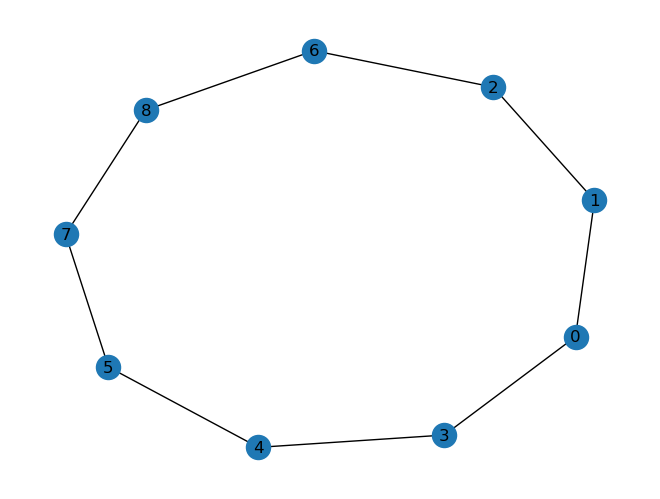

In [38]:
nx.draw(rs.nx_plot(lowest_data[0][1]), with_labels=True)

[['Index:', 479], ['# CNOT:', 2], ['# Hadamard:', 13], ['# Emitter:', 2], ['Depth:', 17]]
[[0, 1], [1, 2], [2, 6], [6, 8], [8, 7], [7, 5], [5, 4], [4, 3], [3, 0]]


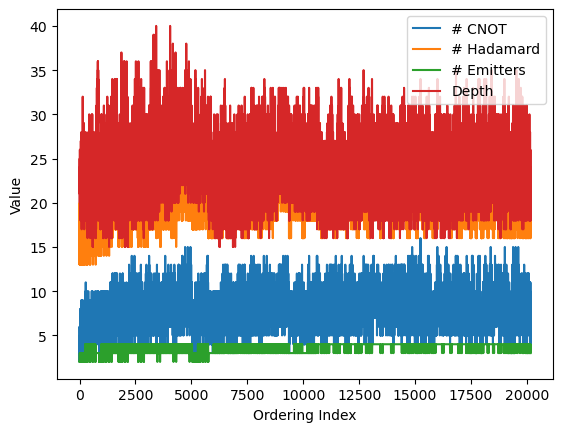

In [39]:
rs.plot_data(0)
print(rs.data[lowest_data[0][1]])
print(rs.orderings[lowest_data[0][1]])

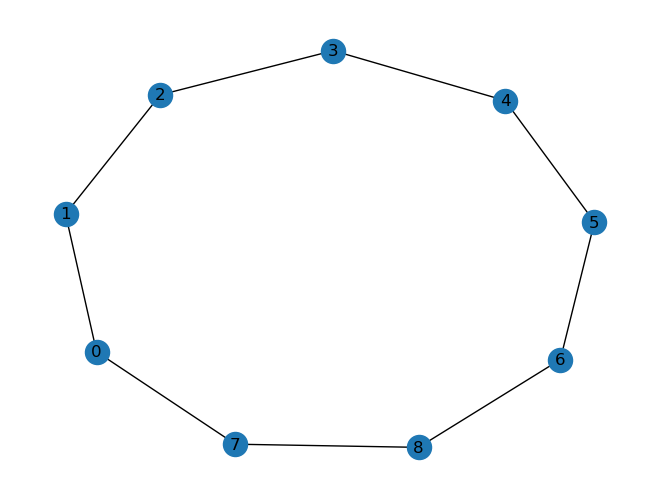

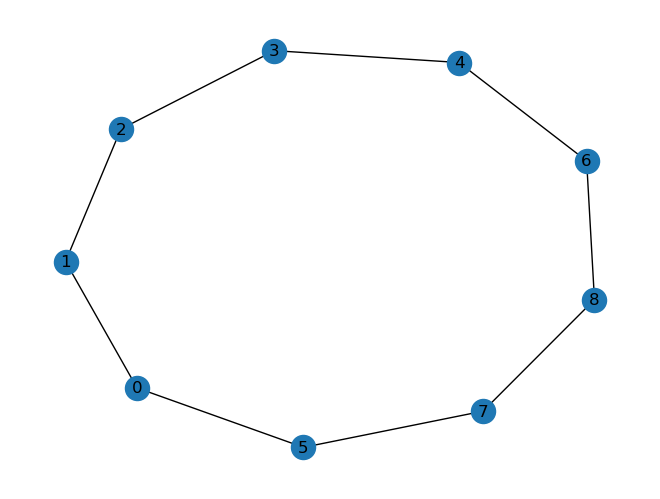

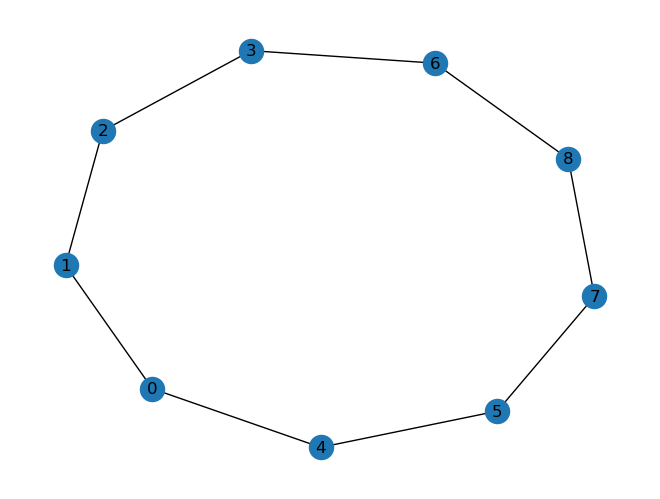

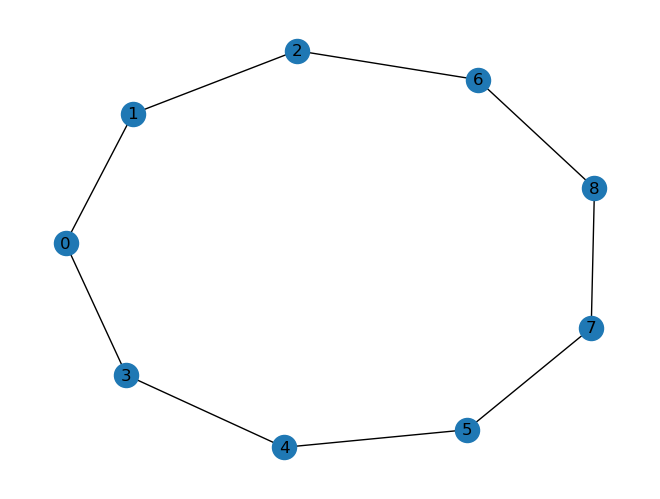

In [40]:
plt.figure(1)
nx.draw(rs.nx_plot(1), with_labels=True)
plt.figure(2)
nx.draw(rs.nx_plot(11), with_labels=True)
plt.figure(3)
nx.draw(rs.nx_plot(71), with_labels=True)
plt.figure(4)
nx.draw(rs.nx_plot(479), with_labels=True)